In [ ]:
]


# Unified Pipeline Products Analysis

This notebook investigates all products generated by the unified pipeline:
1. **Profiles** - Radial density profiles around halos (DMO, Hydro, Replace)
2. **Statistics** - Halo statistics (mass, baryon fractions, particle counts)
3. **2D Maps** - Projected density fields
4. **Lensplanes** - Ray-tracing density planes for lux integration

## Output Locations
- Profiles: `/mnt/home/mlee1/ceph/hydro_replace_fields/L205n625TNG/profiles/`
- Statistics: `/mnt/home/mlee1/ceph/hydro_replace_fields/L205n625TNG/analysis/`
- 2D Maps: `/mnt/home/mlee1/ceph/hydro_replace_fields/L205n625TNG/snap096/projected/`
- Lensplanes: `/mnt/home/mlee1/ceph/hydro_replace_LP/L205n625TNG/`

In [9]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Base paths
FIELDS_BASE = '/mnt/home/mlee1/ceph/hydro_replace_fields/L205n2500TNG'
LP_BASE = '/mnt/home/mlee1/ceph/hydro_replace_LP/L205n2500TNG'
SNAP = 96

print("Pipeline Products Analysis")
print("=" * 50)
print(f"Fields base: {FIELDS_BASE}")
print(f"Lensplanes base: {LP_BASE}")
print(f"Snapshot: {SNAP}")

Pipeline Products Analysis
Fields base: /mnt/home/mlee1/ceph/hydro_replace_fields/L205n2500TNG
Lensplanes base: /mnt/home/mlee1/ceph/hydro_replace_LP/L205n2500TNG
Snapshot: 96


## 1. Density Profiles

The profiles file contains stacked radial density profiles around halos for DMO, Hydro, and Replace models.

In [10]:
# Load profiles
profile_file = os.path.join(FIELDS_BASE, 'profiles', f'profiles_snap{SNAP:03d}.h5')

if os.path.exists(profile_file):
    print(f"Loading profiles from: {profile_file}")
    with h5py.File(profile_file, 'r') as f:
        print("\nFile structure:")
        def print_structure(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"  {name}: {obj.shape}, {obj.dtype}")
            else:
                print(f"  {name}/")
        f.visititems(print_structure)
        
        # Load data - using actual key names from the file
        stacked_dmo = f['stacked_dmo'][:]       # (n_mass_bins, n_radial_bins)
        stacked_hydro = f['stacked_hydro'][:]   # (n_mass_bins, n_radial_bins)
        counts_dmo = f['counts_dmo'][:]
        counts_hydro = f['counts_hydro'][:]
        
        # Also load component breakdowns if available
        if 'stacked_hydro_dm' in f:
            stacked_hydro_dm = f['stacked_hydro_dm'][:]
            stacked_hydro_gas = f['stacked_hydro_gas'][:]
            stacked_hydro_stars = f['stacked_hydro_stars'][:]
        
    print(f"\nProfile shape: {stacked_dmo.shape}")
    print(f"  Rows = mass bins, Cols = radial bins")
else:
    print(f"Profile file not found: {profile_file}")

Loading profiles from: /mnt/home/mlee1/ceph/hydro_replace_fields/L205n2500TNG/profiles/profiles_snap096.h5

File structure:
  counts_dmo: (6, 30), int64
  counts_hydro: (6, 30), int64
  stacked_dmo: (6, 30), float64
  stacked_hydro: (6, 30), float64
  stacked_hydro_dm: (6, 30), float64
  stacked_hydro_gas: (6, 30), float64
  stacked_hydro_stars: (6, 30), float64

Profile shape: (6, 30)
  Rows = mass bins, Cols = radial bins


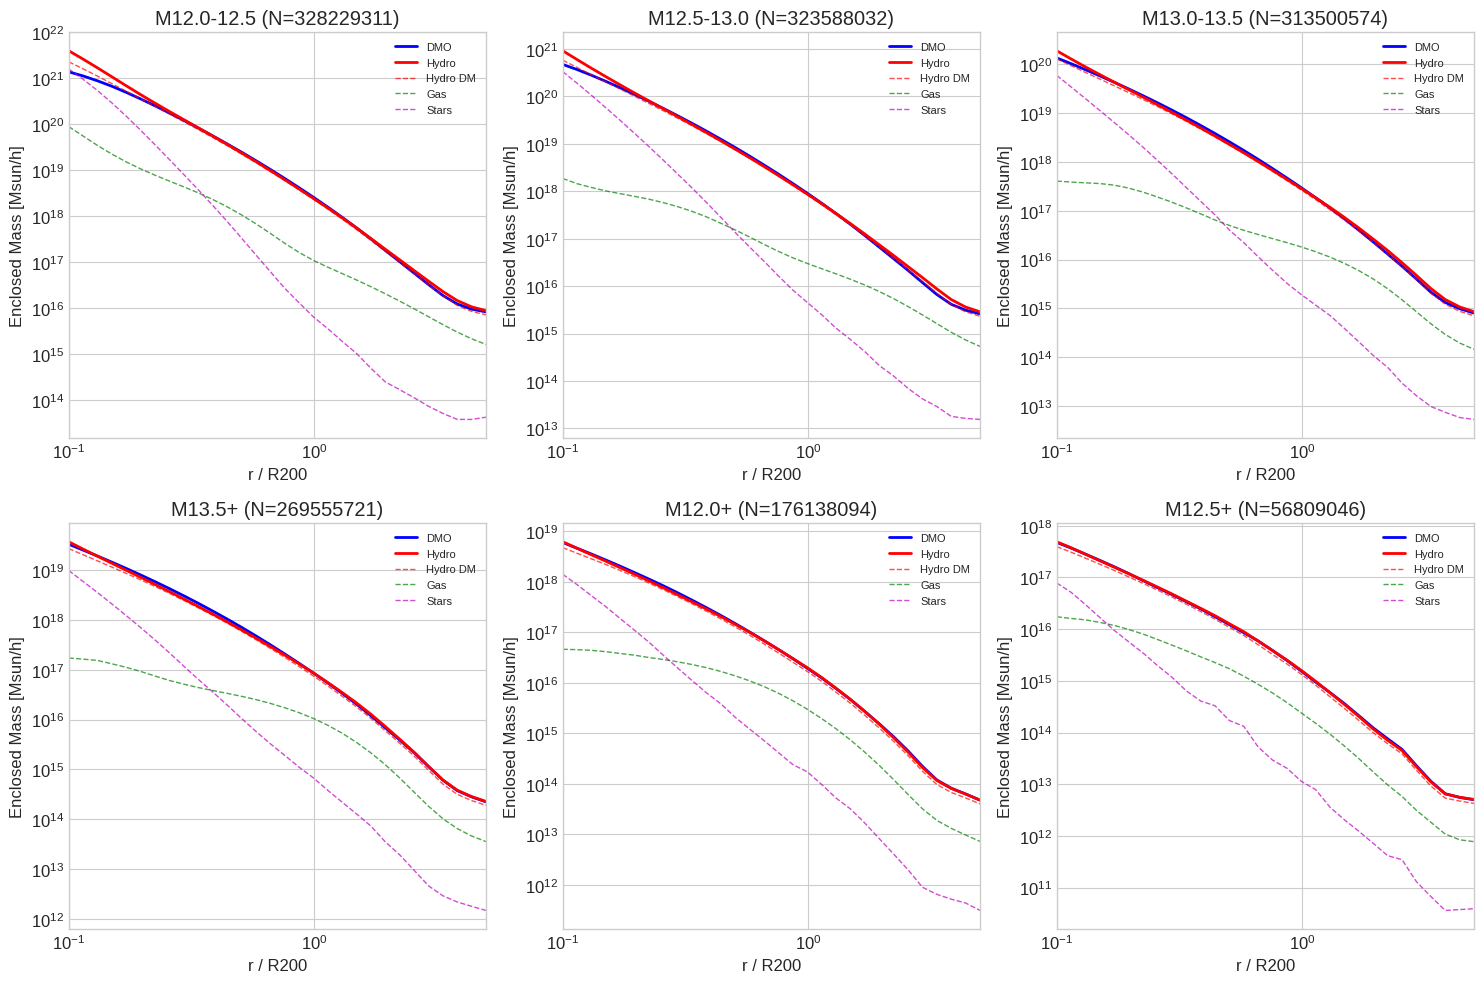

In [11]:
# Plot stacked profiles
if 'stacked_dmo' in dir():
    # Create radial bin centers (assuming log-spaced from 0.1 to 5 R200)
    n_radial_bins = stacked_dmo.shape[1]
    r_centers = np.logspace(np.log10(0.1), np.log10(5.0), n_radial_bins)
    
    # Mass bin labels
    mass_bin_labels = ['M12.0-12.5', 'M12.5-13.0', 'M13.0-13.5', 'M13.5+', 'M12.0+', 'M12.5+']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(min(6, stacked_dmo.shape[0])):
        ax = axes[i]
        
        dmo_prof = stacked_dmo[i]
        hydro_prof = stacked_hydro[i]
        
        # Only plot where we have data
        valid = (dmo_prof > 0) & (hydro_prof > 0)
        
        if np.any(valid):
            ax.loglog(r_centers[valid], dmo_prof[valid], 'b-', lw=2, label='DMO')
            ax.loglog(r_centers[valid], hydro_prof[valid], 'r-', lw=2, label='Hydro')
            
            # Show component breakdown if available
            if 'stacked_hydro_dm' in dir():
                ax.loglog(r_centers[valid], stacked_hydro_dm[i][valid], 'r--', lw=1, alpha=0.7, label='Hydro DM')
                ax.loglog(r_centers[valid], stacked_hydro_gas[i][valid], 'g--', lw=1, alpha=0.7, label='Gas')
                if np.any(stacked_hydro_stars[i][valid] > 0):
                    ax.loglog(r_centers[valid], stacked_hydro_stars[i][valid], 'm--', lw=1, alpha=0.7, label='Stars')
        
        ax.set_xlabel('r / R200')
        ax.set_ylabel('Enclosed Mass [Msun/h]')
        label = mass_bin_labels[i] if i < len(mass_bin_labels) else f'Bin {i}'
        ax.set_title(f'{label} (N={counts_dmo[i].max()})')
        ax.legend(fontsize=8)
        ax.set_xlim(0.1, 5)
    
    plt.tight_layout()
    plt.show()

## 2. Halo Statistics

The statistics file contains per-halo information including masses, baryon fractions, and particle counts.

In [12]:
# Load halo statistics
stats_file = os.path.join(FIELDS_BASE, 'analysis', f'halo_statistics_snap{SNAP:03d}.h5')

if os.path.exists(stats_file):
    print(f"Loading statistics from: {stats_file}")
    with h5py.File(stats_file, 'r') as f:
        print("\nFile structure:")
        def print_structure(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"  {name}: {obj.shape}, {obj.dtype}")
            else:
                print(f"  {name}/")
        f.visititems(print_structure)
        
        # Load key statistics - using actual key names
        log_masses = f['log_masses'][:]          # log10(M_halo)
        m_dmo = f['m_dmo'][:]                    # (n_halos, n_radial_bins)
        m_total = f['m_total'][:]               # Total mass in Hydro (n_halos, n_radial_bins)
        m_dm_hydro = f['m_dm_hydro'][:]         # DM mass in Hydro
        m_gas = f['m_gas'][:]
        m_stellar = f['m_stellar'][:]
        
        # Load fractions
        f_baryon = f['f_baryon'][:]
        f_gas = f['f_gas'][:]
        f_stellar = f['f_stellar'][:]
        ratio_total = f['ratio_total'][:]       # M_hydro / M_dmo
        ratio_dm = f['ratio_dm'][:]             # M_dm_hydro / M_dmo
        
        # Positions and radii
        positions_dmo = f['positions_dmo'][:]
        radii_dmo = f['radii_dmo'][:]
        
    print(f"\nNumber of halos: {len(log_masses)}")
    print(f"Mass range: 10^{log_masses.min():.2f} - 10^{log_masses.max():.2f} Msun/h")
    print(f"Radial bins shape: {m_dmo.shape[1]} (from 0.1 to 5 R200)")
else:
    print(f"Statistics file not found: {stats_file}")

Loading statistics from: /mnt/home/mlee1/ceph/hydro_replace_fields/L205n2500TNG/analysis/halo_statistics_snap096.h5

File structure:
  f_baryon: (28375, 6), float32
  f_gas: (28375, 6), float32
  f_stellar: (28375, 6), float32
  log_masses: (28375,), float32
  m_dm_hydro: (28375, 6), float64
  m_dmo: (28375, 6), float64
  m_gas: (28375, 6), float64
  m_stellar: (28375, 6), float64
  m_total: (28375, 6), float64
  positions_dmo: (28375, 3), float32
  positions_hydro: (28375, 3), float32
  radii_dmo: (28375,), float32
  radii_hydro: (28375,), float32
  ratio_dm: (28375, 6), float32
  ratio_total: (28375, 6), float32

Number of halos: 28375
Mass range: 10^12.00 - 10^14.98 Msun/h
Radial bins shape: 6 (from 0.1 to 5 R200)


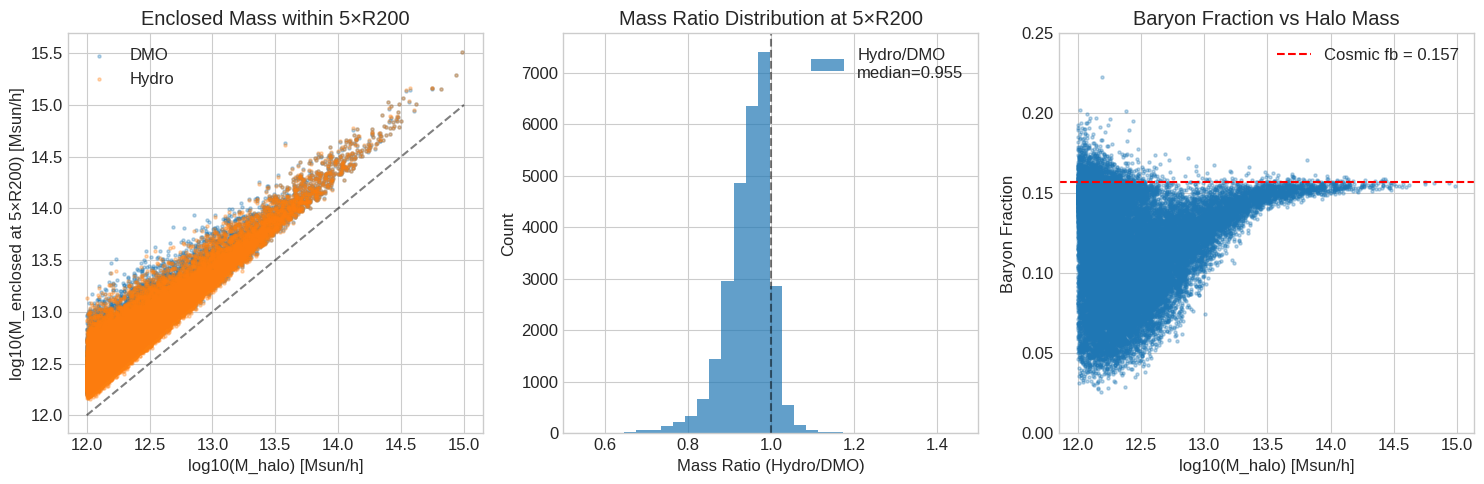

In [13]:
# Plot mass comparisons
if 'log_masses' in dir():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Use the outermost radial bin (index -1) for R200 measurements
    r_idx = -1  # Outermost bin ~ 5 R200
    
    halo_masses = 10**log_masses
    dmo_masses_r200 = m_dmo[:, r_idx]
    hydro_masses_r200 = m_total[:, r_idx]
    
    # Panel 1: Mass in halos comparison
    ax = axes[0]
    ax.scatter(log_masses, np.log10(dmo_masses_r200 + 1), alpha=0.3, s=5, label='DMO')
    ax.scatter(log_masses, np.log10(hydro_masses_r200 + 1), alpha=0.3, s=5, label='Hydro')
    ax.plot([12, 15], [12, 15], 'k--', alpha=0.5)
    ax.set_xlabel('log10(M_halo) [Msun/h]')
    ax.set_ylabel('log10(M_enclosed at 5×R200) [Msun/h]')
    ax.set_title('Enclosed Mass within 5×R200')
    ax.legend()
    
    # Panel 2: Mass ratio distributions
    ax = axes[1]
    valid = (dmo_masses_r200 > 0) & (hydro_masses_r200 > 0)
    ratio = hydro_masses_r200[valid] / dmo_masses_r200[valid]
    ax.hist(ratio, bins=50, alpha=0.7, label=f'Hydro/DMO\nmedian={np.nanmedian(ratio):.3f}')
    ax.axvline(1.0, color='k', ls='--', alpha=0.5)
    ax.set_xlabel('Mass Ratio (Hydro/DMO)')
    ax.set_ylabel('Count')
    ax.set_title('Mass Ratio Distribution at 5×R200')
    ax.legend()
    ax.set_xlim(0.5, 1.5)
    
    # Panel 3: Baryon fraction vs mass
    ax = axes[2]
    cosmic_fb = 0.157  # Planck value
    # Use baryon fraction at R200 (middle bin)
    fb_r200 = f_baryon[:, 3]  # middle-ish radial bin
    ax.scatter(log_masses, fb_r200, alpha=0.3, s=5)
    ax.axhline(cosmic_fb, color='r', ls='--', label=f'Cosmic fb = {cosmic_fb}')
    ax.set_xlabel('log10(M_halo) [Msun/h]')
    ax.set_ylabel('Baryon Fraction')
    ax.set_title('Baryon Fraction vs Halo Mass')
    ax.legend()
    ax.set_ylim(0, 0.25)
    
    plt.tight_layout()
    plt.show()

## 3. 2D Projected Density Maps

The projected density maps are 2D density fields generated from particles projected along one axis.

In [14]:
# Load 2D density maps
map_dir = os.path.join(FIELDS_BASE, f'snap{SNAP:03d}', 'projected')
print(f"Map directory: {map_dir}")

if os.path.exists(map_dir):
    map_files = sorted(os.listdir(map_dir))
    print(f"Available maps: {map_files}")
    
    # Load maps
    maps = {}
    for f in map_files:
        if f.endswith('.npz'):
            name = f.replace('.npz', '')
            data = np.load(os.path.join(map_dir, f))
            maps[name] = data['field']
            print(f"  {name}: shape {maps[name].shape}, range [{maps[name].min():.2e}, {maps[name].max():.2e}]")
else:
    print(f"Map directory not found: {map_dir}")

Map directory: /mnt/home/mlee1/ceph/hydro_replace_fields/L205n2500TNG/snap096/projected
Available maps: ['dmo.npz', 'hydro.npz', 'replace_M12p0.npz']
  dmo: shape (1024, 1024), range [1.24e+11, 5.88e+13]
  hydro: shape (1024, 1024), range [1.29e+11, 6.08e+13]
  replace_M12p0: shape (1024, 1024), range [1.24e+11, 6.08e+13]


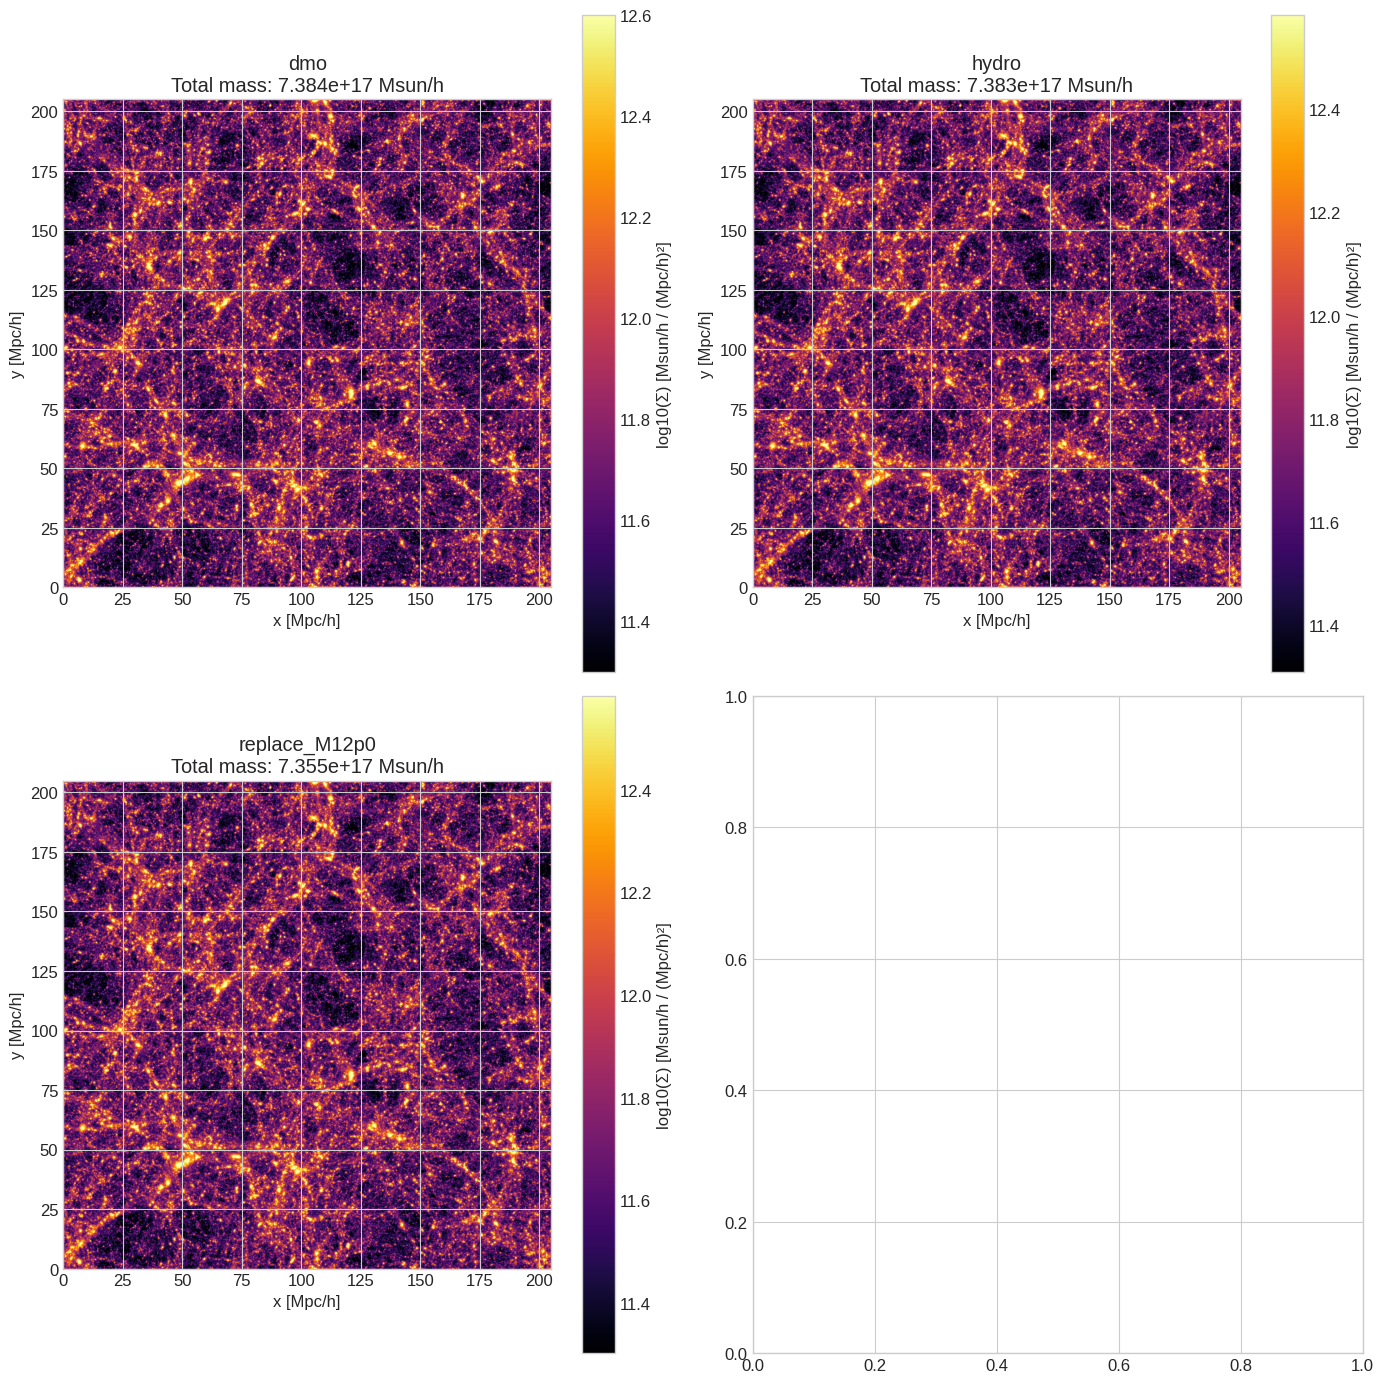

In [15]:
# Visualize 2D maps
if 'maps' in dir() and len(maps) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes = axes.flatten()
    
    BOX_SIZE = 205.0  # Mpc/h
    
    for i, (name, field) in enumerate(list(maps.items())[:4]):
        ax = axes[i]
        
        # Log scale for better visualization
        field_plot = np.log10(field + 1e-10)
        vmin, vmax = np.percentile(field_plot[field_plot > -10], [1, 99])
        
        im = ax.imshow(field_plot, origin='lower', cmap='inferno',
                       extent=[0, BOX_SIZE, 0, BOX_SIZE], vmin=vmin, vmax=vmax)
        ax.set_xlabel('x [Mpc/h]')
        ax.set_ylabel('y [Mpc/h]')
        ax.set_title(f'{name}\nTotal mass: {field.sum():.3e} Msun/h')
        plt.colorbar(im, ax=ax, label='log10(Σ) [Msun/h / (Mpc/h)²]')
    
    plt.tight_layout()
    plt.show()

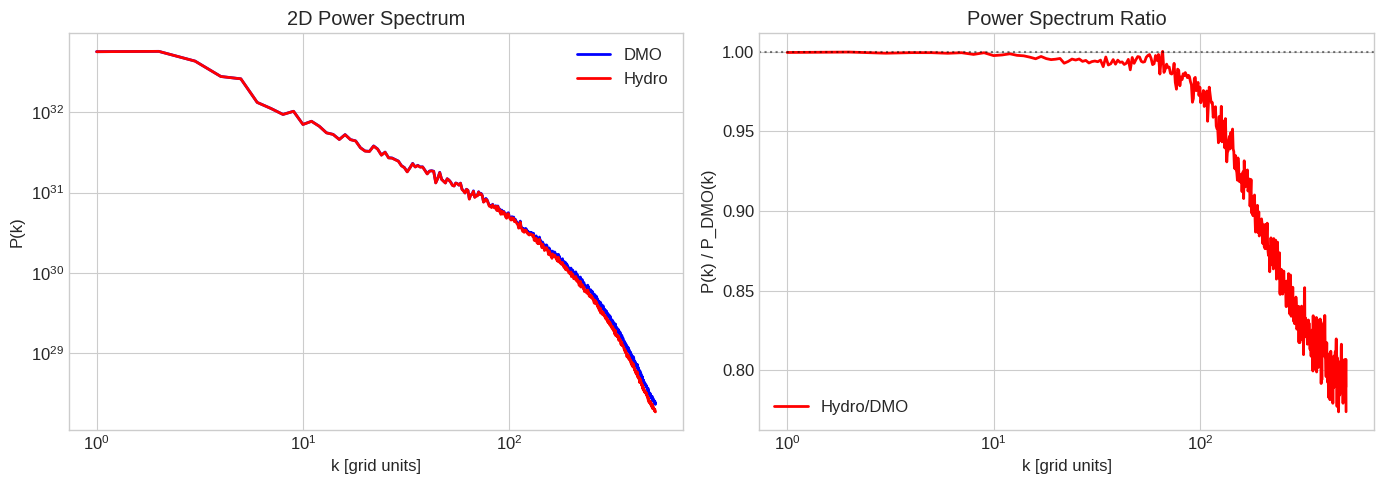

In [17]:
# Compare DMO, Hydro, Replace maps via power spectrum
if 'maps' in dir() and 'dmo' in maps and 'hydro' in maps:
    from scipy import fft
    
    def compute_power_spectrum_2d(field):
        """Compute 2D power spectrum of a field."""
        n = field.shape[0]
        fft_field = fft.fft2(field)
        power = np.abs(fft_field)**2
        
        # Radial averaging
        kx = fft.fftfreq(n) * n
        ky = fft.fftfreq(n) * n
        kx, ky = np.meshgrid(kx, ky)
        k = np.sqrt(kx**2 + ky**2)
        
        # Bin the power spectrum
        k_bins = np.arange(0.5, n//2, 1)
        k_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
        power_binned = np.zeros(len(k_centers))
        
        for i in range(len(k_centers)):
            mask = (k >= k_bins[i]) & (k < k_bins[i+1])
            if np.sum(mask) > 0:
                power_binned[i] = np.mean(power[mask])
        
        return k_centers, power_binned
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Compute power spectra
    k_dmo, P_dmo = compute_power_spectrum_2d(maps['dmo'])
    k_hydro, P_hydro = compute_power_spectrum_2d(maps['hydro'])
    
    # Left: Absolute power spectra
    ax = axes[0]
    ax.loglog(k_dmo, P_dmo, 'b-', lw=2, label='DMO')
    ax.loglog(k_hydro, P_hydro, 'r-', lw=2, label='Hydro')
    
    if 'replace_M12p5' in maps:
        k_rep, P_rep = compute_power_spectrum_2d(maps['replace_M12p5'])
        ax.loglog(k_rep, P_rep, 'g--', lw=2, label='Replace M12.5+')
    
    ax.set_xlabel('k [grid units]')
    ax.set_ylabel('P(k)')
    ax.set_title('2D Power Spectrum')
    ax.legend()
    
    # Right: Ratio to DMO
    ax = axes[1]
    ax.semilogx(k_hydro, P_hydro / P_dmo, 'r-', lw=2, label='Hydro/DMO')
    if 'replace_M12p5' in maps:
        ax.semilogx(k_rep, P_rep / P_dmo, 'g--', lw=2, label='Replace/DMO')
    ax.axhline(1.0, color='k', ls=':', alpha=0.5)
    ax.set_xlabel('k [grid units]')
    ax.set_ylabel('P(k) / P_DMO(k)')
    ax.set_title('Power Spectrum Ratio')
    ax.legend()
    # ax.set_ylim(0.8, 1.2)
    
    plt.tight_layout()
    plt.show()

## 4. Lensplanes

Lensplanes are density fields formatted for the `lux` ray-tracing code. Each file contains a 2D density slice.

**Structure:**
- `LP_00/` to `LP_09/` - 10 realizations (different random transforms)
- `lenspot00.dat`, `lenspot01.dat` - front and back depth slices for snapshot 96
- File format: `[int32: grid] [float64[grid²]: delta*dz] [int32: grid]`

In [18]:
# Explore lensplane directory structure
print(f"Lensplane base: {LP_BASE}")
print()

if os.path.exists(LP_BASE):
    # List top-level contents
    contents = sorted(os.listdir(LP_BASE))
    print("Top-level contents:")
    for item in contents:
        path = os.path.join(LP_BASE, item)
        if os.path.isdir(path):
            sub_contents = os.listdir(path)
            print(f"  {item}/ ({len(sub_contents)} items)")
        else:
            size = os.path.getsize(path)
            print(f"  {item} ({size/1024:.1f} KB)")
    
    # Check DMO structure
    dmo_path = os.path.join(LP_BASE, 'dmo')
    if os.path.exists(dmo_path):
        print(f"\nDMO realizations: {sorted(os.listdir(dmo_path))}")
        lp00_path = os.path.join(dmo_path, 'LP_00')
        if os.path.exists(lp00_path):
            print(f"Files in LP_00: {sorted(os.listdir(lp00_path))}")
else:
    print(f"Lensplane base not found: {LP_BASE}")

Lensplane base: /mnt/home/mlee1/ceph/hydro_replace_LP/L205n2500TNG

Top-level contents:
  dmo/ (10 items)
  hydro/ (10 items)
  hydro_replace_Ml_1.00e12_Mu_3.16e12_R_0.5/ (10 items)
  hydro_replace_Ml_1.00e12_Mu_3.16e12_R_1.0/ (10 items)
  hydro_replace_Ml_1.00e12_Mu_3.16e12_R_3.0/ (10 items)
  hydro_replace_Ml_1.00e12_Mu_3.16e12_R_5.0/ (10 items)
  hydro_replace_Ml_1.00e13_Mu_3.16e13_R_0.5/ (10 items)
  hydro_replace_Ml_1.00e13_Mu_3.16e13_R_1.0/ (7 items)
  hydro_replace_Ml_3.16e12_Mu_1.00e13_R_0.5/ (10 items)
  hydro_replace_Ml_3.16e12_Mu_1.00e13_R_1.0/ (10 items)
  hydro_replace_Ml_3.16e12_Mu_1.00e13_R_3.0/ (10 items)
  hydro_replace_Ml_3.16e12_Mu_1.00e13_R_5.0/ (10 items)
  transforms.h5 (10.6 KB)

DMO realizations: ['LP_00', 'LP_01', 'LP_02', 'LP_03', 'LP_04', 'LP_05', 'LP_06', 'LP_07', 'LP_08', 'LP_09']
Files in LP_00: ['lenspot00.dat', 'lenspot01.dat', 'lenspot02.dat', 'lenspot03.dat', 'lenspot04.dat', 'lenspot05.dat', 'lenspot06.dat', 'lenspot07.dat', 'lenspot08.dat', 'lenspot0

In [19]:
def read_lensplane(filepath):
    """Read lux binary lensplane file.
    
    Format: [int32: grid] [float64[grid²]: data] [int32: grid]
    """
    with open(filepath, 'rb') as f:
        grid1 = np.fromfile(f, dtype=np.int32, count=1)[0]
        data = np.fromfile(f, dtype=np.float64, count=grid1*grid1)
        grid2 = np.fromfile(f, dtype=np.int32, count=1)[0]
        
        if grid1 != grid2:
            print(f"Warning: header ({grid1}) != footer ({grid2})")
        
        return data.reshape(grid1, grid1), grid1

# Read a sample lensplane
lp_file = os.path.join(LP_BASE, 'dmo', 'LP_00', 'lenspot00.dat')
if os.path.exists(lp_file):
    lp_data, grid = read_lensplane(lp_file)
    print(f"Lensplane file: {lp_file}")
    print(f"Grid size: {grid}")
    print(f"Data shape: {lp_data.shape}")
    print(f"Data range: [{lp_data.min():.6e}, {lp_data.max():.6e}]")
    print(f"Data sum: {lp_data.sum():.6e}")
    print(f"Non-zero pixels: {np.sum(lp_data != 0)} / {lp_data.size}")
else:
    print(f"Lensplane file not found: {lp_file}")

Lensplane file: /mnt/home/mlee1/ceph/hydro_replace_LP/L205n2500TNG/dmo/LP_00/lenspot00.dat
Grid size: 4096
Data shape: (4096, 4096)
Data range: [2.328330e+09, 7.319048e+12]
Data sum: 3.823531e+17
Non-zero pixels: 16777216 / 16777216


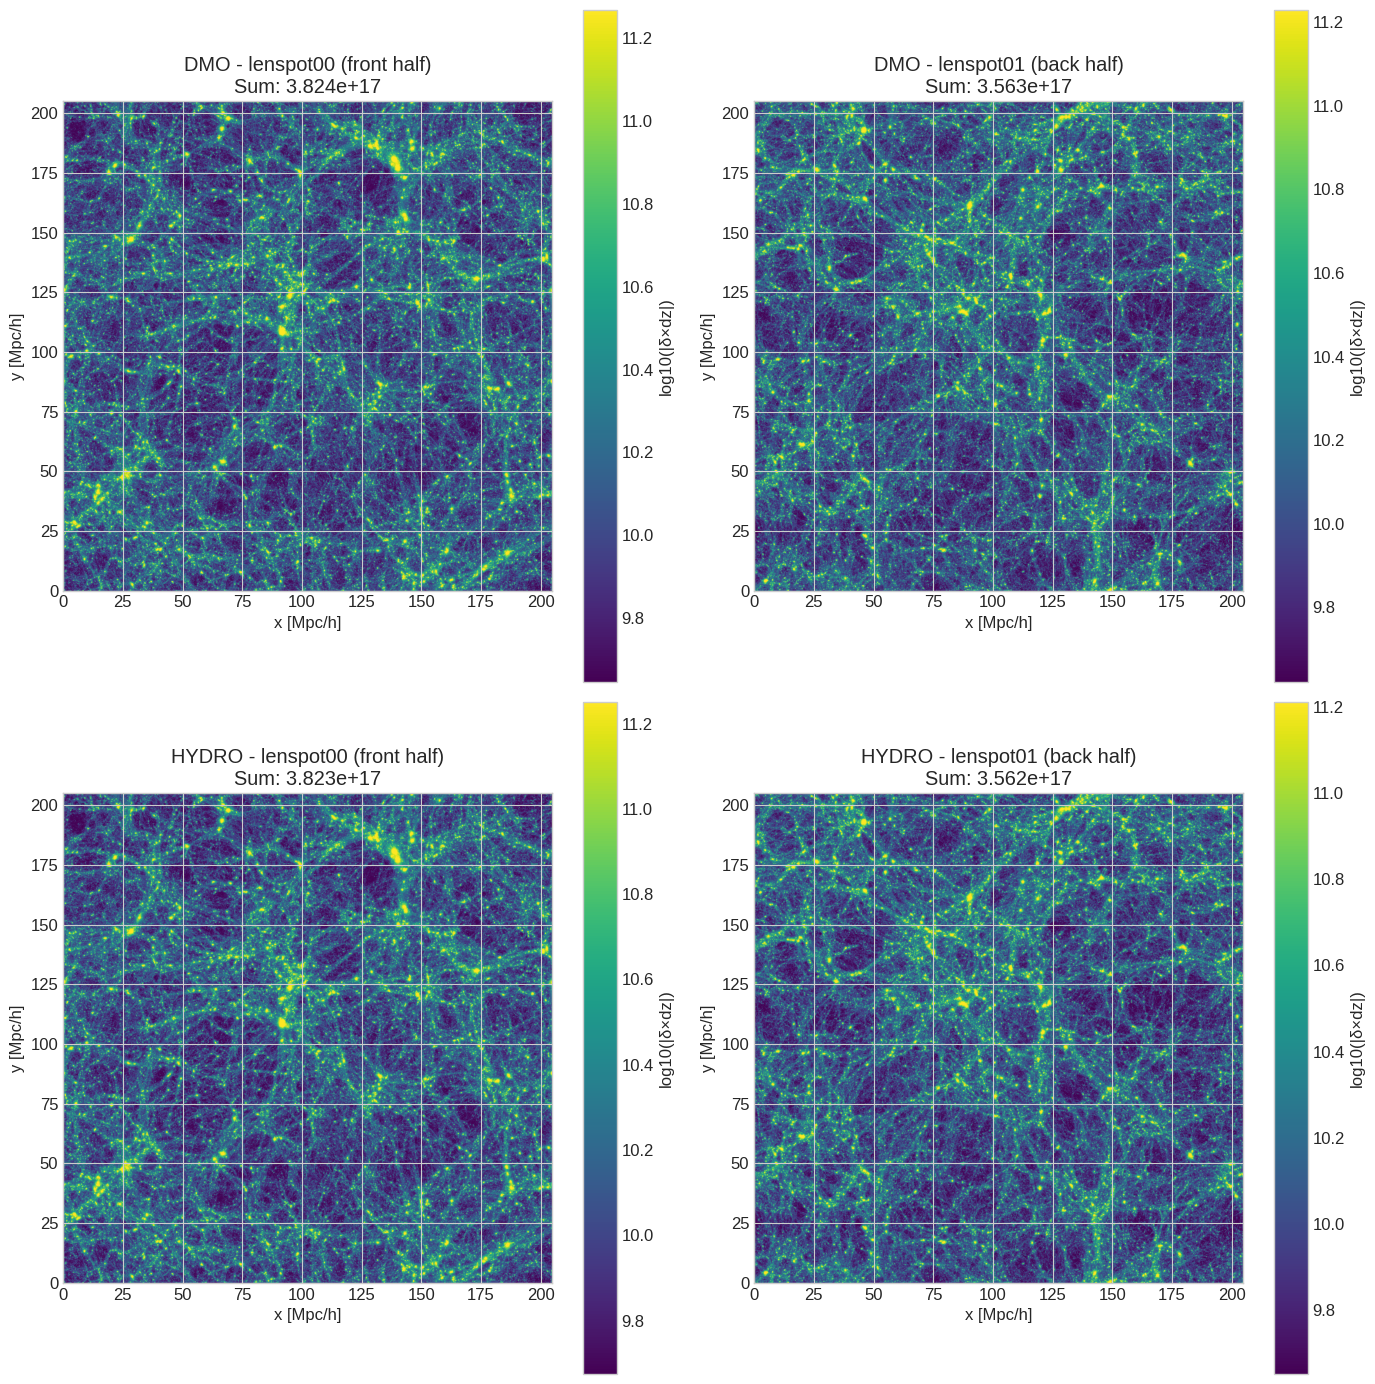

In [20]:
# Visualize lensplanes: DMO vs Hydro comparison for same realization
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

BOX_SIZE = 205.0  # Mpc/h

models = ['dmo', 'hydro']
pps_slices = [0, 1]  # lenspot00 (front) and lenspot01 (back)

for i, model in enumerate(models):
    for j, pps in enumerate(pps_slices):
        ax = axes[i, j]
        lp_file = os.path.join(LP_BASE, model, 'LP_00', f'lenspot{pps:02d}.dat')
        
        if os.path.exists(lp_file):
            data, grid = read_lensplane(lp_file)
            
            # Log scale visualization - handle empty/zero data
            data_abs = np.abs(data)
            if data_abs.max() > 0:
                data_plot = np.log10(data_abs + data_abs[data_abs > 0].min() * 0.01)
                valid_data = data_plot[np.isfinite(data_plot)]
                if len(valid_data) > 0:
                    vmin, vmax = np.percentile(valid_data, [1, 99])
                else:
                    vmin, vmax = -20, 0
            else:
                data_plot = np.zeros_like(data)
                vmin, vmax = -1, 1
            
            im = ax.imshow(data_plot, origin='lower', cmap='viridis',
                          extent=[0, BOX_SIZE, 0, BOX_SIZE], vmin=vmin, vmax=vmax)
            ax.set_xlabel('x [Mpc/h]')
            ax.set_ylabel('y [Mpc/h]')
            ax.set_title(f'{model.upper()} - lenspot{pps:02d} ({"front" if pps==0 else "back"} half)\nSum: {data.sum():.3e}')
            plt.colorbar(im, ax=ax, label='log10(|δ×dz|)')
        else:
            ax.text(0.5, 0.5, f'File not found:\n{lp_file}', 
                   transform=ax.transAxes, ha='center', va='center')

plt.tight_layout()
plt.show()

In [ ]:
# Compare lensplanes across realizations - should have different transforms
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for real_idx in range(10):
    ax = axes.flatten()[real_idx]
    lp_file = os.path.join(LP_BASE, 'dmo', f'LP_{real_idx:02d}', 'lenspot00.dat')
    
    if os.path.exists(lp_file):
        data, grid = read_lensplane(lp_file)
        
        # Log scale visualization - handle empty/zero data safely
        data_abs = np.abs(data)
        if data_abs.max() > 0:
            data_plot = np.log10(data_abs + data_abs[data_abs > 0].min() * 0.01)
            valid_data = data_plot[np.isfinite(data_plot)]
            if len(valid_data) > 0:
                vmin, vmax = np.percentile(valid_data, [1, 99])
            else:
                vmin, vmax = -20, 0
        else:
            data_plot = np.zeros_like(data)
            vmin, vmax = -1, 1
        
        ax.imshow(data_plot, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_title(f'LP_{real_idx:02d}')
        ax.axis('off')
    else:
        ax.text(0.5, 0.5, 'Not found', transform=ax.transAxes, ha='center')

plt.suptitle('DMO Lensplanes (lenspot00) across 10 realizations\nEach should have different random transform', y=1.02)
plt.tight_layout()
plt.show()

## 5. Transform Verification

Check that transforms are stored correctly and consistent across models.

In [22]:
# Load and inspect transforms
transform_file = os.path.join(LP_BASE, 'transforms.h5')

if os.path.exists(transform_file):
    print(f"Loading transforms from: {transform_file}")
    with h5py.File(transform_file, 'r') as f:
        print("\nFile structure:")
        def print_structure(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"  {name}: {obj.shape}, {obj.dtype}")
            else:
                print(f"  {name}/")
        f.visititems(print_structure)
        
        # Load transforms
        proj_dirs = f['proj_dirs'][:]
        displacements = f['displacements'][:]
        flips = f['flips'][:]
        
        print(f"\nTransform arrays:")
        print(f"  proj_dirs: {proj_dirs.shape} - projection direction (0=x, 1=y, 2=z)")
        print(f"  displacements: {displacements.shape} - translation offsets")
        print(f"  flips: {flips.shape} - flip boolean")
        
        print(f"\nProj dirs (realization, snapshot):")
        print(proj_dirs)
        
        print(f"\nFlips (realization, snapshot):")
        print(flips.astype(int))
else:
    print(f"Transform file not found: {transform_file}")

Loading transforms from: /mnt/home/mlee1/ceph/hydro_replace_LP/L205n2500TNG/transforms.h5

File structure:
  displacements: (10, 20, 3), float64
  flips: (10, 20), bool
  proj_dirs: (10, 20), int64
  snapshot_order: (20,), int64

Transform arrays:
  proj_dirs: (10, 20) - projection direction (0=x, 1=y, 2=z)
  displacements: (10, 20, 3) - translation offsets
  flips: (10, 20) - flip boolean

Proj dirs (realization, snapshot):
[[0 0 2 1 0 1 0 0 0 2 1 2 2 2 1 0 0 0 0 2]
 [0 1 1 1 2 1 2 1 1 2 2 2 2 1 0 2 2 0 2 0]
 [1 0 1 2 2 0 1 1 2 2 1 0 2 0 2 2 0 2 1 2]
 [2 0 0 2 0 2 2 2 0 2 2 1 0 1 1 1 1 1 1 0]
 [1 2 1 0 2 1 2 1 0 0 0 0 2 0 1 2 0 2 1 2]
 [1 1 1 2 2 2 0 0 1 0 2 1 0 2 1 1 1 2 2 1]
 [1 2 2 1 1 0 2 2 1 2 2 0 1 2 1 0 1 0 1 0]
 [0 2 0 1 1 1 0 1 2 1 2 0 0 0 2 0 2 1 1 0]
 [2 0 1 2 0 0 2 0 1 1 1 2 0 1 2 1 2 2 1 1]
 [2 0 1 1 2 2 1 0 2 2 1 0 1 0 1 0 0 0 2 1]]

Flips (realization, snapshot):
[[1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1]
 [0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 1]
 [0 1 0 0 0 1 1 0 1 0 

## 6. Summary Statistics

In [23]:
# Summary of all pipeline products
print("=" * 60)
print("PIPELINE PRODUCTS SUMMARY")
print("=" * 60)

# Check profiles
profile_file = os.path.join(FIELDS_BASE, 'profiles', f'profiles_snap{SNAP:03d}.h5')
if os.path.exists(profile_file):
    with h5py.File(profile_file, 'r') as f:
        n_halos = f['dmo_profiles'].shape[0]
    print(f"✓ Profiles: {n_halos} halos")
else:
    print("✗ Profiles: NOT FOUND")

# Check statistics
stats_file = os.path.join(FIELDS_BASE, 'analysis', f'halo_statistics_snap{SNAP:03d}.h5')
if os.path.exists(stats_file):
    with h5py.File(stats_file, 'r') as f:
        n_halos = len(f['halo_masses'][:])
    print(f"✓ Statistics: {n_halos} halos")
else:
    print("✗ Statistics: NOT FOUND")

# Check 2D maps
map_dir = os.path.join(FIELDS_BASE, f'snap{SNAP:03d}', 'projected')
if os.path.exists(map_dir):
    map_files = [f for f in os.listdir(map_dir) if f.endswith('.npz')]
    print(f"✓ 2D Maps: {len(map_files)} files - {map_files}")
else:
    print("✗ 2D Maps: NOT FOUND")

# Check lensplanes
if os.path.exists(LP_BASE):
    models = [d for d in os.listdir(LP_BASE) if os.path.isdir(os.path.join(LP_BASE, d))]
    print(f"✓ Lensplanes: {len(models)} models")
    for model in sorted(models)[:5]:  # Show first 5
        model_path = os.path.join(LP_BASE, model)
        realizations = [d for d in os.listdir(model_path) if d.startswith('LP_')]
        if realizations:
            sample_lp = os.path.join(model_path, realizations[0])
            files = os.listdir(sample_lp)
            print(f"    {model}: {len(realizations)} realizations, {len(files)} files per LP")
else:
    print("✗ Lensplanes: NOT FOUND")

# Check transforms
transform_file = os.path.join(LP_BASE, 'transforms.h5')
if os.path.exists(transform_file):
    with h5py.File(transform_file, 'r') as f:
        shape = f['proj_dirs'].shape
    print(f"✓ Transforms: shape {shape} (realizations × snapshots)")
else:
    print("✗ Transforms: NOT FOUND")

print("=" * 60)

PIPELINE PRODUCTS SUMMARY


KeyError: "Unable to open object (object 'dmo_profiles' doesn't exist)"

# Lens plane tests

In [ ]:
lenspot_file = '/mnt/home/mlee1/ceph/hydro_replace_LP/L205n2500TNG/hydro_replace_Ml_1.00e12_Mu_3.16e12_R_0.5/LP_00/lenspot14.dat'